<a href="https://colab.research.google.com/github/NaimaZouidi/Frenshi-chatbot/blob/main/Frenshi_chatbot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Frenshi Chatbot

This notebook trains a chatbot called Frenshi on the administrative formalities in France for foreign students to help them during their stay!

# Set-up enviroment
To run this colab you will need to import some python modules such as Tensorflow, pandas, etc.



In [1]:
import tensorflow as tf
import json
import pandas as pd
import string
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, GlobalAvgPool1D, Flatten
from tensorflow.keras.models import Model
from sklearn.preprocessing import LabelEncoder

# Help-in functions

This function creates an NLP model with an LSTM transformer.


```
input_shape:
output_len: is the number of output tags or classes.
```



In [2]:
def createModel(input_shape, output_len):
  i = Input(shape=(input_shape))
  x = Embedding(vocabulary + 1, 10)(i)
  x = LSTM(10, return_sequences=True)(x)
  x = Flatten()(x)
  x = Dense(output_len, activation="softmax")(x)
  model = Model(i, x)
  return model

# Preparing Data set
In order to train Frenshi we need to create a dataset, a json file here, which will hold user's questions and the best answers to it underneath a tag or class such as: greeting inputs/answers, goodbye inputs/answers, etc.


In [3]:
%%writefile datasetFR.json
{"intents":
[
   {
      "tag": "greetingDay",
      "input": ["Salut", "Salut Frenshi", "Bonjour", "Bonjour frenshi", "Coucou", "coucou Frenshi", "Frenshi!"],
      "responses" : ["Bienvenue! Je suis Frenshi! je suis là pour vous aider et accompagner dans vos démarches administratives en france. Les démarches administratives sont souvent un vrai casse-téte, d'autant plus pour les étudiants étrangers arrivant dans un nouveau pays. Mais ne vous inquiétez pas! Je suis là pour vous! Pour commenencer veuillez choisir parmi les propositions suivantes:\nCAF, titre de sèjour ou sècurité sociale",
      "Bonjour! Je suis Frenshi! je suis là pour vous aider et accompagner dans vos démarches administratives en france. Les démarches administratives sont souvent un vrai casse-téte, d'autant plus pour les étudiants étrangers arrivant dans un nouveau pays. Mais ne vous inquiétez pas! Je suis là pour vous! Pour commenencer veuillez choisir parmi les propositions suivantes:\nCAF, titre de sèjour ou sècurité sociale",
      "Oh salut! Je suis Frenshi! je suis là pour vous aider et accompagner dans vos démarches administratives en france. Les démarches administratives sont souvent un vrai casse-téte, d'autant plus pour les étudiants étrangers arrivant dans un nouveau pays. Mais ne vous inquiétez pas! Je suis là pour vous! Pour commenencer veuillez choisir parmi les propositions suivantes:\nCAF, titre de sèjour ou sècurité sociale"]
    },
    {
      "tag": "greetingEvening",
      "input": ["Bonsoir", "Bonsoir frenshi"],
      "responses" : ["Bienvenue! Je suis Frenshi! je suis là pour vous aider et accompagner dans vos démarches administratives en france. Les démarches administratives sont souvent un vrai casse-téte, d'autant plus pour les étudiants étrangers arrivant dans un nouveau pays. Mais ne vous inquiétez pas! Je suis là pour vous! Pour commenencer veuillez choisir parmi les propositions suivantes:\nCAF, titre de sèjour ou sècurité sociale",
      "Bonsoir! Je suis Frenshi! je suis là pour vous aider et accompagner dans vos démarches administratives en france. Les démarches administratives sont souvent un vrai casse-téte, d'autant plus pour les étudiants étrangers arrivant dans un nouveau pays. Mais ne vous inquiétez pas! Je suis là pour vous! Pour commenencer veuillez choisir parmi les propositions suivantes:\nCAF, titre de sèjour ou sècurité sociale",
      "Oh salut! Je suis Frenshi! je suis là pour vous aider et accompagner dans vos démarches administratives en france. Les démarches administratives sont souvent un vrai casse-téte, d'autant plus pour les étudiants étrangers arrivant dans un nouveau pays. Mais ne vous inquiétez pas! Je suis là pour vous! Pour commenencer veuillez choisir parmi les propositions suivantes:\nCAF, titre de sèjour ou sècurité sociale"]
    },
    {
      "tag": "goodbyeDay",
      "input": ["Au revoir!", "Au revoir Frenshi!", "Merci beaucoup! Au revoir", "Merci beaucoup! Au revoir Frenshi", "Oh! Merci beaucoup", "Oh! Merci beaucoup Frenshi!", "Merci beaucoup! Bonne journée", "Merci beaucoup! Bonne journée Frenshi", "Merci!", "Merci Frenshi!", "Bonne journée", "Bonne journée Frenshi!"],
      "responses" : ["Au revoir! N'hesitez pas à revenir vers moi si vous avez d'autres questions concernant vos démarches admininstratives en France!",
      "Je t'en prie! N'hesitez pas à me poser d'autres question si vous avez besoin d'aide ou d'assistance dans vos démarches admininstratives en France!",
      "Bonne journée! N'hesitez pas à revenir vers moi si vous avez d'autres questions concernant vos démarches admininstratives en France!"]
    },
    {
      "tag": "goodbyeEvening",
      "input": ["Merci beaucoup! Bonne soirée", "Merci beaucoup! Bonne soirée Frenshi!", "Merci! Bonne soirée", "Merci! Bonne soirée Frenshi!", "Bonne soirée", "Bonne soirée Frenshi!"],
      "responses" : ["Au revoir! N'hesitez pas à revenir vers moi si vous avez d'autres questions concernant vos démarches admininstratives en France!",
      "Je t'en prie! N'hesitez pas à me poser d'autres question si vous avez besoin d'aide ou d'assistance dans vos démarches admininstratives en France!",
      "Bonne journée! N'hesitez pas à revenir vers moi si vous avez d'autres questions concernant vos démarches admininstratives en France!",
      "Bonne soirée! N'hesitez pas à revenir vers moi si vous avez d'autres questions concernant vos démarches admininstratives en France!"]
     },
    {
      "tag": "Resident permit",
      "input":["Titre de sèjour", "Pourquoi un titre de sèjour?", "Quel titre de sèjour faut-t-il demander?", "Quel titre de sèjour pour un étudiant?"],
      "responses": ["Le titre de sèjour est un document qui vous permet de circuler et franchir les frontières de l'espace Schengen. En tant qu'étudiant étranger vous devez demander un titre de sèjour mention étudiant ou chercheur si vous étes venu faire une thèse de doctorat.",
      "En france, le titre de sèjour vous permet de circuler et franchir les frontières de l'espace Schengen. En tant qu'étudiant étranger vous devez demander un titre de sèjour mention étudiant ou chercheur si vous étes venu faire une thèse de doctorat.",
      "Le titre de sèjour en france justifie vos droits et vous permet de circuler et franchir les frontières de l'espace Schengen. En tant qu'étudiant étranger vous devez demander un titre de sèjour mention étudiant ou chercheur si vous étes venu faire une thèse de doctorat."]
    },
    {
      "tag": "Documents for Resident permit",
      "input": ["Quelles sont les pièces justificatives pour demander un titre de séjour?", "Pièces justificatives pour demander un titre de sèjour", "Comment formuler ma demande de titre de séjour?", "Quels sont les documents néccessaires pour demander un titre de séjour?", "Documents néccessaires titre de séjour", "Pièces justificatives titre de séjour"],
      "responses": ["Voici la liste des pièces justificatives que vous aurez besoin pour préparer de votre demande de titre de sèjour:\n1- Etat Civile.\n3- Photographie d'identité récente datant de moins de 3 mois.\n4- Justificatifs de domicile datant d'au moins de 6 mois.\n5- Le motif de votre sèjour.\n6- Des ressources financieres.",
      "Quant aux pièces justificatives que vous aurez besoin pour préparer votre demande de titre de sèjour, ils sont les suivantes:\n1- Etat Civile.\n3- Photographie d'identité récente datant de moins de 3 mois.\n4- Justificatifs de domicile datant d'au moins de 6 mois.\n5- Le motif de votre sèjour.\n6- Des ressources financieres.",
      "Pour formuler votre demande de titre de sèjour de titre de séjour ous aurez besoin des pièces justificatives suivantes:\n1- Etat Civile.\n3- Photographie d'identité récente datant de moins de 3 mois.\n4- Justificatifs de domicile datant d'au moins de 6 mois.\n5- Le motif de votre sèjour.\n6- Des ressources financieres."]
    },
    {
      "tag": "Civil state",
      "input": ["Etat civile", "Quel document pour l'état civile?", "Pièce justificative état civile", "Quelle pièce justificative pour l'état civile?"],
      "responses": ["Pour l'état civile il vaut faut un titre de sèjour en cours de validitè, s'il s'agit d'un renouvellement, ou juste votre passeport. En effet, si vous n'avez pas de titre de sejour en cours de validité, veuillez joindre les pages de votre passeport relatives à l'état civil, aux dates de validité, aux cachets d'éntrée et aux visas y a compris ton visa long séjour VTS.",
      "Quant à l'état civile il vaut faut un titre de sèjour en cours de validitè, s'il s'agit d'un renouvellement, ou juste votre passeport. En effet, si vous n'avez pas de titre de sejour en cours de validité, veuillez joindre les pages de votre passeport relatives à l'état civil, aux dates de validité, aux cachets d'éntrée et aux visas y a compris ton visa long séjour VTS."]
    },
    {
      "tag": "Identity photograph",
      "input": ["Quelle photographie d'identité?", "Photographie d'identité", "Format de photographie d'identité", "Quelle format pour la photographie d'identité", "Photo d'identité", "Quelle photo d'identité?", "Format de photo d'identité", "Quelle format pour le photo d'identité?"],
      "responses":["La photographie d'identité prend la forme une e-photo datant de moins de 6 mois.",
      "La photographie d'identité prend la forme d'une e-photo et doit avoir été prise il y a moins de 6 mois."]
    },
    {
      "tag": "E-photo",
      "input": ["C'est quoi un e-photo", "e-photo", "Que ce que cela veut dire e-photo?"],
      "responses": ["L'e-photo est une photo d'identité dématérialisée avec une signature numérique.",
      "L'e-photo présente une photo d'identité dématérialisée avec une signature numérique."]
    },
    {
      "tag": "Reason for staying",
      "input": ["Quels documents pour le motif de mon séjour?", "Motif de sèjour", "Quelles pièces justificatives pour le motif de sèjour", "motif de sèjour étudiant"],
      "responses": ["Concernant le motif de votre sèjour, il faut fournir une certificat d'inscription ou justificatif de réinscription auprés de votre établissement d'enseignement supérieur.\nVous aurez aussi besoin de:\n1- Vos relevés de notes.\n2- Votre dernier diplôme obtenu.\n3- Une attestation de réussite s'il s'agit d'une renouvellement.\nSi la mention de titre de séjour qui vous soliciter est chercheur vous devez joindre également une convention d'acceuil de laboratoire de recherche dont laquelle vous allez éffectuer votre thèse de doctorat.",
      "Pour le motif de votre sèjour il s'agit de fournir une certificat d'inscription ou justificatif de réinscription auprés de votre établissement d'enseignement supérieur.\nVous aurez aussi besoin de:\n1- Vos relevés de notes.\n2- Votre dernier diplôme obtenu.\n3- Une attestation de réussite s'il s'agit d'une renouvellement.\nSi la mention de titre de séjour qui vous soliciter est chercheur vous devez joindre également une convention d'acceuil de laboratoire de recherche dont laquelle vous allez éffectuer votre thèse de doctorat."]
    },
    {
      "tag":"Apply for resident permit",
      "input": ["Comment éffectuer mon demarche de titre de sèjour?", "Demander un titre de sèjour", "Où deposer ma demande de titre de sèjour?", "Comment soliciter un titre de séjour?", "soliciter un titre de séjour"],
      "responses": ["Si vous souhaitez éffectuer votre demarche de titre de sèjour vous pouvez précèder à travers le site internet du gouvernement français ci-dessous:\nhttps://administration-etrangers-en-france.interieur.gouv.fr/particuliers/#/",
      "Pour éffectuer votre demarche de titre de sèjour vous pouvez précèder à travers le site internet du gouvernement français ci-dessous:\nhttps://administration-etrangers-en-france.interieur.gouv.fr/particuliers/#/",
      "Pour demander un titre de sèjour vous pouvez précèder à travers le site internet du gouvernement français ci-dessous:\nhttps://administration-etrangers-en-france.interieur.gouv.fr/particuliers/#/"]
    },
    {
      "tag": "Proof of address",
      "input": ["Quel justificatif de domicile?", "Justificatif de domicile", "Le justificatif de domicile"],
      "responses": ["Le justificatif de domocile peut prendre plusieurs formes. Veuillez s'il vous plait me preciser si vous étes locataire, héberger à l'hotel ou chez un particulier. Merci!",
      "Pour le justificatif de domocile, il peut prendre plusieurs formes. Veuillez s'il vous plait me preciser si vous étes locataire, héberger à l'hotel ou chez un particulier. Merci!"]
    },
    {
      "tag": "A student renting a flat",
      "input": ["Je suis locataire!", "locataire", "Etudiant locataire"],
      "responses":["Si vous étes locataire, vous pouvez joindre un des justificatifs de domicile suivant:\n- Une facture d'électricité, gaz, eau, internet, fixe ou mobile. \n- Une copie du bail de location.\n- Une copie d'une quittance de loyer ou de taxe d'habitation.",
      "Dans le cas où vous étes locataire il faut joindre un des justificatifs de domicile suivant:\n- Une facture d'électricité, gaz, eau, internet, fixe ou mobile. \n- Une copie du bail de location.\n- Une copie d'une quittance de loyer ou de taxe d'habitation."]
    },
    {
      "tag": "Student staying at a hotel",
      "input": ["Je suis héberger à l'hotel", "Je suis logé à l'hotel", "Je suis à l'hotel"],
      "responses":["Si vous étes heberger à l'hotel, vous pouvez joindre un des justificatifs de domicile suivant:\n - Une attestation de l'hotel.\n- Une copie de votre facture du dernier mois.",
      "Dans le cas où vous étes heberger à l'hotel, vous pouvez joindre un des justificatifs de domicile suivant:\n - Une attestation de l'hotel.\n- Une copie de votre facture du dernier mois."]
    },
    {
      "tag":"Student staying with family or relatives",
      "input":["Je suis héberger chez un particulier", "Je suis logé chez un particulier", "Je vie chez un particulier"],
      "responses":["Si vous ètes héberger chez un particulier, vous pouvez joindre un des justificatifs de domicile suivant:\n- Une attestation de l'hèbergeant datée et signée.\n- Une copie de sa Carte d'Identité Nationale(CIN) ou de sa carte de sèjour.\n- Un justificatif de domicile de l'hebergeant si l'adresse inscrite sur son CIN n'est pas à jour.",
      "Dans le cas où vous ètes héberger chez un particulier, vous pouvez joindre un des justificatifs de domicile suivant:\n- Une attestation de l'hèbergeant datée et signée.\n- Une copie de sa Carte d'Identité Nationale(CIN) ou de sa carte de sèjour.\n- Un justificatif de domicile de l'hebergeant si l'adresse inscrite sur son CIN n'est pas à jour."]
    },
    {
      "tag": "Supporting documents Financial resources",
      "input": ["Quels justificatifs pour les ressources financieres?", "Justificatifs Resources financiers", "Quels documents pour les resources financieres"],
      "responses": ["Les justificatifs des resources financiers peut dependre de votre situation. Veuillez s'il vous plait me preciser si vous étes pris en charge par un tiers, boursier, salarié ou vous avez des resources financiers suffisantes pour vos études.",
      "En ce que concerne les justificatifs des resources financiers ceux-ci peut dependre de votre situation. Veuillez s'il vous plait me preciser si vous étes pris en charge par un tiers, boursier, salarié ou vous avez des resources financiers suffisantes pour vos études.",
      "Pour les justificatifs des resources financiers cela peut dependre de votre situation. Veuillez s'il vous plait me preciser si vous étes pris en charge par un tiers, boursier, salarié ou vous avez des resources financiers suffisantes pour vos études."]
    },
    {
      "tag": "Student holding a scholarship",
      "input": ["Je suis boursier", "Boursier", "Etudiant boursier", "J'ai un bourse", "Je bénéficier d'un bourse"],
      "responses": ["Si vous ètes boursier, vous pouvez joindre une attestation justificative selon votre situation. Si vous étes boursier dans votre pays d'origine vous aurez besoin d'une attestation de bourse de l'organisme payeur du pays d'origine. Sinon, vous devez fournir une attestation de financement de gouvernement francaise ou programme européen qui finance vos études.",
      "Dans le cas où si vous ètes boursier, vous pouvez joindre une attestation justificative selon votre situation. Si vous étes boursier dans votre pays d'origine vous aurez besoin d'une attestation de bourse de l'organisme payeur du pays d'origine. Sinon, vous devez fournir une attestation de financement de gouvernement francaise ou programme européen qui finance vos études.",
      "Etant donnée que vous ètes boursier, vous pouvez joindre une attestation justificative selon votre situation. Si vous étes boursier dans votre pays d'origine vous aurez besoin d'une attestation de bourse de l'organisme payeur du pays d'origine. Sinon, vous devez fournir une attestation de financement de gouvernement francaise ou programme européen qui finance vos études."]
    },
    {
      "tag": "Student cared for by a third party",
      "input" : ["Je suis pris en charge par un tiers", "pris en charge par un tiers", "Etudiant pris en charge par un tiers", "Je suis pris en charge par mes parents", "Mes parents prendent en charge les frais de mes études", "Je suis pris en charge par un proche", "Un de mes proches prend en charge les frais de mes études"],
      "responses": ["Si vous étes pris en charge par un tiers, vous pouvez joindre les attestations suivantes:\n- Une attestation de la banque du tiers justifiant de la programmation de virements réguliers vers votre compte.\n- Une attestation sur l'honneur de versement des sommes permettant d'atteindre le montant requis de 615$/mois à joindre avec un justificatif d'identité du tiers.",
      "Dans le cas où vous étes pris en charge par un tiers, vous pouvez joindre les attestations suivantes:\n- Une attestation de la banque du tiers justifiant de la programmation de virements réguliers vers votre compte.\n- Une attestation sur l'honneur de versement des sommes permettant d'atteindre le montant requis de 615$/mois à joindre avec un justificatif d'identité du tiers.",
      "Etant donnée que vous étes pris en charge par un tiers, vous pouvez joindre les attestations suivantes:\n- Une attestation de la banque du tiers justifiant de la programmation de virements réguliers vers votre compte.\n- Une attestation sur l'honneur de versement des sommes permettant d'atteindre le montant requis de 615$/mois à joindre avec un justificatif d'identité du tiers."]
    },
    {
      "tag": "Employée",
      "input": ["Je suis salarié", "Etudiant salarié", "salarié", "Oui! je suis salarié", "Je travail"],
      "responses": ["Si vous étes salarié, vous pouvez fournir vos trois derniéres fiches de paie.",
      "Dans le cas où vous étes salarié, vous pouvez fournir vos trois derniéres fiches de paie.",
      "Etant donnée que vous étes salarié, vous pouvez fournir vos trois derniéres fiches de paie."]
    },
    {
      "tag": "Student with sufficient financial resources",
      "input": ["J'ai des ressources financieres suffisantes!", "ressources financieres suffisantes", "Je dispose de resources financieres suffisantes", "Oui j'ai des resources financieres suffisantes"],
      "responses": ["Si vous disposez des ressources financieres suffisantes vous devez fournir l'attestation bancaire de solde créditeur suffisant.",
      "Dans le cas où vous disposez des ressources financieres suffisantes vous devez fournir l'attestation bancaire de solde créditeur suffisant.",
      "Etant donnée que vous disposez des ressources financieres suffisantes vous devez fournir l'attestation bancaire de solde créditeur suffisant."]
    },
    {
      "tag": "CAF",
      "input":["CAF", "C'est quoi la CAF?", "Aide au logement", "Aide au logement étudiant étranger"],
      "responses": ["Les étudiants étrangers en France peuvent avoir des difficultés à louer un logement, particuliérement sur Paris ou les grandes villes universitaires. La Caisse d'Allocations Familiales (CAF) est un organisme française de droit privés, présent dans chaque département francaise qui verse certaines prestations destinées à lutter contre la pauvreté tel que le RSA ou la Prime d'activité, mais également des aides au logement tel que l'APL.",
      "Comme tout les étudiant francais, les étudiants étrangers en France peuvent avoir des difficultés à louer un logement, particuliérement sur Paris ou les grandes villes universitaires. La Caisse d'Allocations Familiales (CAF) est un organisme française de droit privés, présent dans chaque département francaise qui verse certaines prestations destinées à lutter contre la pauvreté tel que le RSA ou la Prime d'activité, mais également des aides au logement tel que l'APL.",
      "Les étudiants étrangers en France peuvent rencontrer des difficultés pour trouver un logement, en particulier dans les grandes villes universitaires comme Paris. La CAF est une organisation de droit privé située dans chaque département français et offre des prestations pour lutter contre la pauvreté telles que le RSA ou la Prime d'activité, ainsi que des aides au logement telles que l'APL."]
    },
    {
      "tag": "APL",
      "input": ["APL", "C'est quoi de l'APL?", "Peux-je demande de l'APL?", "peux-je bénéficie de l'APL", "Aide personalisé au logement", "Prestation CAF étudiant"],
      "responses": ["L'APL n'est pas spécifiquement destinée aux étudiants, elle s'adresse à toutes personnes ayant de faibles revenus. La bonne nouvelle c'est que même si vous étes étudiant étranger vous pouvez prétendre à l'APL, cette aide peut faire toute la différence! Toutefois, vous devez vous acquitter de certaines condition obligatoires.",
      "L'APL s'adresse à toutes les personnes ayant de faibles revenus et n'est pas spécifiquement destinée aux étudiants. La bonne nouvelle c'est que vous pouvez demander l'APL même si vous êtes étudiant étranger, ce qui peut faire toute la différence! Mais vous devez respecter certaines conditions.",
      "L'APL n'est pas spécifiquement destinée aux étudiants et s'adresse à toutes les personnes ayant de faibles revenus. La bonne nouvelle, c'est que même si vous êtes étudiant étranger, vous pouvez demander APL, ce qui peut faire toute la différence! Cependant, il est nécessaire de respecter certaines conditions."]
    },
    {
      "tag": "Apply to APL",
      "input": ["Comment faire une demande d'APL?", "Demande d'APL", "Demander l'APL", "Demarche d'APL", "formuler ma demande d'APL", "Comment formuler ma demande d'APL?"],
      "responses": ["Les étudiants étrangers, comme les étudiants français doivent formuler leur demande en ligne sur le site internet de la caf ci-dessous:\nhttps://wwwd.caf.fr/wps/portal/caffr/aidesetdemarches/mesdemarches/faireunedemandedeprestation#DAL\n\nEn remplissant votre demande vous devez précisez que vous n'êtes pas allocataire, en effet, comme c'est votre premiére demande vous ne posséder pas d'espace personnel sur le site de la CAF. Donc il fault que vous créer un nouveau compte. Une fois que cela est fait vous pourrez vous connecter à votre compte CAF en ligne.",
      "Les étudiants étrangers, tout comme les étudiants français, doivent remplir leur demande en ligne sur le site internet de la Caf en suivant les instructions suivantes:\nRendez-vous sur le site Web suivant:\nhttps://wwwd.caf.fr/wps/portal/caffr/aidesetdemarches/mesdemarches/faireunedemandedeprestation#DALVous\npuis indiquer dans votre demande que vous n'êtes pas allocataire. Vue que c'est votre première demande et donc vous n'avez pas d'espace personnel sur le site internet de la CAF. Par conséquent, vous devez créer un nouveau compte. Une fois terminé, vous pourrez accéder à votre compte CAF en ligne."]
    },
    {
      "tag": "APL requirements",
      "input": ["Comment pretendre à l'APL?", "Conditions attribution APL", "conditions d'APL", "Suis-je éligible à l'APL"],
      "responses": ["Pour pretendre de l'APL il faut: \n- Habiter 8 mois minimum dans votre logement étudiant au cours de l'année. \n- Votre logement fait l'objet d'une convention par l'état comme les cités universitaires, les foyers HLM, les logement socials, etc.\nAttention : Si vos parents vivent également en France et percoivent des allocations familiales ces derniers peuvent se voir retirer cette prestation si vous faites une demande d'APL. La régle est la même pour les ressortissants français. De plus si vous habitez en colocation et que vous faites une demande d'APL, votre colocataire se verra dans l'obligatoire d'en faire également, s'il ne fait pas la demande d'APL cela peut impacter votre éligibilité.",
      "Pour être éligible l'APL, il faut que vous habitez au moins 8 mois dans votre logement étudiant au cours de l'année et que votre logement fait l'objet d'une convention gouvernementale telle que les cités universitaires, les foyers HLM, les logements sociaux, etc. Si vos parents résident également en France et reçoivent des allocations familiales, il est possible que cette prestation leur soit retirée si vous demandez une APL. Les citoyens français sont soumis à la même réglementation. De plus, si vous habitez en colocation et faites une demande d'APL, votre colocataire doit également en faire, sinon cela peut affecter votre éligibilité."]
    },
    {
      "tag": "APL calculation",
      "input": ["Comment-a-t-il calculé l'APL?", "Calcul d'APL", "Montant d'APL", "Simulation d'APL", "Calcul d'APL"],
      "responses": ["L'APL est calculée en fonction du montant du loyer, de vos ressources (revenus des parents, vos revenus, prestations familiales), son attribution n'est donc pas automatique, et son montant peut dépendre de votre situation. Pour simuler le montant d'aide APL, veuillez s'il vous plait consulter les site internet suivant:\nhttps://wwwd.caf.fr/wps/portal/caffr/aidesetdemarches/mesdemarches/faireunesimulation/lelogement#/preparation",
      "L'attribution de l'APL n'est pas automatique et peut dependre de votre situation. En effet, le montant de l'APL peut varier en fonction du montant du loyer, de vos ressources (revenus des parents, vos revenus, prestations familiales). Pour faire une simulation de montant de votre aide d'APL, veuillez s'il vous consulter les site internet suivant:\nhttps://wwwd.caf.fr/wps/portal/caffr/aidesetdemarches/mesdemarches/faireunesimulation/lelogement#/preparation"]
    },
    {
      "tag": "Supporting documents APL",
      "input":["Pièces justificatives d'APL", "Quelles pièces justificatives pour l'APL?", "Les documents néccessaires pour formuler ma demande d'APL", "Quels sont les documents néccessaires pour formuler ma demande d'APL?"],
      "responses": ["Pour formuler votre demande d'APL vous devez obligatoirement avoir un compte bancaire français et donc fournir un RIB. Il vous faut également:\n1. Votre contrat de bail.\n2. Une attestation de domocile, remplie par le propriétaire du logement.\n3. Une justificatifs de vos revenus sur les deux derniéres années, vous pouvez fournir les déclarations de revenus de ces deux derniéres année de votre pays d'origine.\n4. Votre carte d'identité nationale ou passeport, ainsi que votre extrait d'acte de naissance avec une traduction certifiée en français.\n\nSi vous étes citoyen de l'UE vous devrez fournir une attestation d'inscription à l'université et votre carte d'assurance Européenne d'assurance maladie.\nSi vous étes non-européen vous devrez joindre un titre de séjour qui soit valide au minimum pour toute l'année universitaire en cours ainsi qu'un justificatif d'inscription au régime de la sécurité sociale étudiante Ameli.",
      "Pour faire une demande d'APL, vous devez avoir un compte bancaire en France et fournir un RIB. De plus, vous devez fournir:\n1. Votre contrat de bail.\n2. Une attestation de domocile remplie par le propriétaire du logement.\n3. Pour justifier vos revenus des deux dernières années, vous pouvez fournir des déclarations de revenus de ces deux dernières années provenant de votre pays d'origine.\n4. Un passeport ou une carte d'identité nationale, ainsi qu'un extrait d'acte de naissance avec une traduction certifiée en français.\nVous devrez fournir une attestation d'inscription à l'université ainsi qu'une carte d'assurance maladie Européenne si vous êtes citoyen de l'UE.\nSi vous n'êtes pas européen, vous devrez joindre au moins un titre de séjour valide pour toute l'année."]
    },
    {
      "tag": "First APL payment",
      "input": ["Quand peux-je reçois ma première versement d'APL?", "Première versement d'APL", "Quand recevoir ma première versement d'APL", "Quand sera ma premiére versement d'APL?"],
      "responses": ["Comme vous ne pourrez pas faire une demande d'APL qu'après votre emmènagement, vous recevez votre premier versement au moins un mois aprés votre emmènagement. Par exemple, Si vous emménagez au mois de septembre votre premier versement peut commencer seulement au début du mois d'octobre.",
      "Vue que vous ne pourrez pas faire une demande d'APL qu'après votre emmènagement, vous recevrez votre premier versement au moins un mois après votre emmènagement. Par exemple, si vous emménagez en septembre, votre premier versement ne peut commencer qu'au début d'octobre."]
    },
    {
      "tag": "Social security",
      "input": ["Sècurité sociale", "C'est quoi la sécurité sociale?", "Ameli", "Peux-je bénéficie d'une couverture sociale en France?", "Quelle couverture sociale en France?"],
      "responses": ["La sècurité sociale vous permet de bènèficier de la prise en charge de vos frais de santè durant votre séjour en France. Trois phases de dèmarches sont à prévoir.",
      "Pendant votre séjour en France, vous pouvez bénéficier de la prise en charge de vos frais de santé grâce à la sécurité sociale. Il est nécessaire de prévoir trois phases de démarches."]
    },
    {
      "tag": "First stage social security",
      "input": ["Phase 1 de demande de sécurité sociale", "La premiére phase de demande de sècurité sociale", "Phase 1 sécurité sociale", "Première phase sécurité sociale", "Quelle est la première phase de demande de sécurité sociale?", "Quelle est la phase 1 de demande de sécurité sociale?", "En quoi consiste la première phase de demande de sécurité sociale", "En quoi consiste la phase 1 de demande de sécurité sociale"],
      "responses": ["Durant cette phase, la sécurité sociale vous demande de saisir vos informations personnelles et de déposer les documents justificatifs afin de créer votre espace personne sur le site internet ci-dessous:\nhttps://etudiant-etranger.ameli.fr/#/.",
      "Dans la première phase de votre demande et afin de créer votre espace personnel, la sécurité sociale vous demande de saisir vos informations personnelles et de déposer les documents justificatifs sur le site internet ci-dessous:\nhttps://etudiant-etranger.ameli.fr/#/",
      "Pour cette phase de votre demande de sécurité sociale vous devez saisir vos informations personnelles et de déposer les documents justificatifs sur le site internet ci-dessous:\nhttps://etudiant-etranger.ameli.fr/#/"]
    },
    {
      "tag": "Preferred doctor",
      "input": ["Médecin traitant", "Pourquoi un médecin traitant?", "C'est quoi un médicin traitant?", "A quoi sert d'avoir un médicin traitant?"],
      "responses": ["Le médecin traitant vous garanti un meilleur suivi médical et des soins mieux remboursés de la sécurité sociale.",
      "Le médecin traitant vous permet d'avoir un suivi médical et des soins mieux remboursés par la sécurité sociale.",
      "Pour mieux rembourser vos soins par la sécurité sociale et avoir un meilleur suivi médical, il faut dessiner un médecin traitant."]
    },
    {
      "tag": "Supplementary health insurance",
      "input": ["Mutuelle etudiant", "Complémentaire santé?", "Pourquoi avoir une complémentaire santé?", "C'est quoi une complémentaire santé?", "A quoi sert d'avoir une complémentaire santé?"],
      "responses": ["La complémentaire santé sert à compléter vos remboursements de l'Assurance Maladie et diminuer votre reste à charge, qui est de l'ordre de 30%.",
      "Afin de reduire votre reste à charge, vous pouvez demander une complémentaire santé qui sert à compléter vos remboursements qui sont de l'ordre de 70%.",
      "La sécurité sociale offre la possibilté de compléter vos remboursements en adhérant à une Complémentaire santé. Cela sert à diminuer votre reste à charge qui est de l'ordre de 30%."]
    },
    {
      "tag" : "Health insurance account",
      "input": ["compte Ameli", "A quoi sert le compte Ameli?", "C'est quoi le compte Ameli", "Pourquoi avoir un compte Ameli?"],
      "responses": ["Le compte Ameli permet de suivre vous remboursements, modifier vous informations personnelles, poser vos questions via ameliBot, qui présente le chatbot de l'Assurance Maladie.",
      "Avec votre compte Ameli, vous pouvez suivre vos remboursements, modifier vos informations personnelles et poser des questions avec ameliBot, le chatbot de l'Assurance Maladie.",
      "La sécurité sociale mis à votre disposition un compte personnel Ameli. Celle ci vous permet de suivre vos remboursements, modifier vos informations personnelles et poser des questions avec ameliBot, le chatbot de l'Assurance Maladie."]
    },
    {
      "tag": "Health insurance card",
      "input": ["Carte vitale", "C'est quoi la carte vitale", "A quoi sert la carte vitale", "Pourquoi avoir une carte vitale?"],
      "responses": ["Votre carte Vitale contient tous les renseignements nécessaires au remboursement de vos frais de santé en France. En la présentant à votre médecin, vous avez ainsi l'assurance d'être automatiquement remboursé en une semaine, sans avoir besoin d'envoyer de feuille de soins.\n Attention: Il est nécessaire de mettre à jour votre carte vitale une fois par an!",
      "En France, votre carte Vitale contient toutes les informations nécessaires pour rembourser vos frais de santé. En la présentant à votre médecin, vous avez l'assurance d'être automatiquement remboursé en une semaine sans avoir besoin d'envoyer de feuille de soins.\nAttention: votre carte vitale doit être mise à jour une fois par an!",
      "Votre carte Vitale contient toutes les informations dont vous avez besoin pour rembourser vos frais de santé en France. Vous avez l'assurance d'être automatiquement remboursé en une semaine sans avoir besoin d'envoyer de feuille de soins en la présentant à votre médecin. \nAttention: votre carte vitale doit être mise à jour chaque année!"]
    },
    {
      "tag": "Update health insurance card",
      "input": ["Mettre à jour ma carte vitale", "Comment mettre à jour ma carte vitale?", "Où mettre à jour ma carte vitale?"],
      "responses": ["Pour mettre à jour votre carte vitale, veuillez vous rendre chez la pharmacie la plus proche de chez vous.",
      "Veuillez s'il vous plait vous rendre à la pharmacie la plus proche de chez vous pour mettre à jour votre carte vitale.",
      "Afin de mettre à jour votre carte vitale, Veuillez s'il vous plait vous rendre à la pharmacie la plus proche de chez vous."]
    },
    {
      "tag": "Download Ameli app",
      "input": ["Application Ameli", "Comment télécharger l'application Ameli?", "Télécharger l'application Ameli", "Où télécharger l'application Ameli", "App Ameli", "Télécharger l'app Ameli", "Où télécharger l'app Ameli?", "Comment télécharger l'app Ameli"],
      "responses": ["L'application Ameli peut être télécharger sur le google play store via l'address ci-dessous:\nhttps://play.google.com/store/apps/datasafety?id=fr.cnamts.it.activity&hl=fr&gl=US",
      "Le téléchargement de l'application Ameli peut être effectué sur le Google Play Store à l'adresse suivante:\nhttps://play.google.com/store/apps/datasafety?id=fr.cnamts.it.activity&hl=fr&gl=US",
      "Si vous souhaitez télécharger l'application ameli, vous pouvez faire cela via l'address ci-dessous:\nhttps://play.google.com/store/apps/datasafety?id=fr.cnamts.it.activity&hl=fr&gl=US"]
    }

]
}

Overwriting datasetFR.json


    {
      "tag": "Apply for Supplementary health insurance",
      "input": [""],
      "responses": [""]
    },
        {
      "tag": "Apply for health insurance card",
      "input": [""],
      "responses": [""]
    },

# Importing Dataset
As we saved the dataset as json. we need to import it into a dataframe in order to train our NLP model.

In [4]:
with open("datasetFR.json") as dbfr:
  dataFR = json.load(dbfr)

In [5]:
tags = []
inputs = []
responses = {}
for intent in dataFR["intents"]:
  responses[intent["tag"]] = intent["responses"]
  for line in intent["input"]:
    inputs.append(line)
    tags.append(intent["tag"])

Here we convert data to a dataframe with the following two columns:


```
inputs: the user's question.
tags: the corresponding tag or class to the user's question in order to identify the best answer to it.
```





In [6]:
data = pd.DataFrame({"inputs":inputs,"tags":tags})

In [7]:
data.head(5)

,inputs,tags
0,Salut,greetingDay
1,Salut Frenshi,greetingDay
2,Bonjour,greetingDay
3,Bonjour frenshi,greetingDay
4,Coucou,greetingDay


# Preprocessing
NLP models can't understand text accordangly. So we need to preprocess the user's input or question by removing punctuations and converting it to lowercase.

In [8]:
data['inputs'] = data["inputs"].apply(lambda wrd:[ltrs.lower() for ltrs in wrd if ltrs not in string.punctuation])
data['inputs'] = data["inputs"].apply(lambda wrd: ''.join(wrd))

In [9]:
data.head(5)

,inputs,tags
0,salut,greetingDay
1,salut frenshi,greetingDay
2,bonjour,greetingDay
3,bonjour frenshi,greetingDay
4,coucou,greetingDay


# Tokenizing the dataset
Tokenization is as important as text preprocessing. It converts a sequence of text into smaller parts, also known as tokens. These tokens can be as small as characters or as long as words. The main reason behind this process is that it helps machines understand human language by breaking it down into bite-sized pieces, which are easier to analyze than whole sentences.

In [10]:
#Tokenize the data
tokenizer = Tokenizer(num_words=2000);
tokenizer.fit_on_texts(data['inputs']);
train = tokenizer.texts_to_sequences(data['inputs'])
#Apply padding
x_train = pad_sequences(train)
#Encoding output to numeric data
labelEnc = LabelEncoder()
y_train = labelEnc.fit_transform(data['tags'])

In [11]:
input_shape = x_train.shape[1]
print(input_shape)

12


In [12]:
vocabulary = len(tokenizer.word_index)
print("The number of unique words is: ", vocabulary)
output_len = labelEnc.classes_.shape[0]
print("The output length is: ", output_len)

The number of unique words is:  168
The output length is:  35


# Creating an NLP model to classifier the user's input by tags
Here we'll create and train an NLP model to classifier the user's input by tags or classes in order to identify the best answer to it.


In [13]:
model = createModel(input_shape, output_len)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 12)]              0         
                                                                 
 embedding (Embedding)       (None, 12, 10)            1690      
                                                                 
 lstm (LSTM)                 (None, 12, 10)            840       
                                                                 
 flatten (Flatten)           (None, 120)               0         
                                                                 
 dense (Dense)               (None, 35)                4235      
                                                                 
Total params: 6765 (26.43 KB)
Trainable params: 6765 (26.43 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [14]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics="accuracy")

In [15]:
history = model.fit(x_train, y_train, epochs = 200)

Epoch 1/200
6/6 [==============================] - 5s 15ms/step - loss: 3.5542 - accuracy: 0.0234
Epoch 2/200
6/6 [==============================] - 0s 13ms/step - loss: 3.5484 - accuracy: 0.0760
Epoch 3/200
6/6 [==============================] - 0s 22ms/step - loss: 3.5431 - accuracy: 0.0877
Epoch 4/200
6/6 [==============================] - 0s 12ms/step - loss: 3.5382 - accuracy: 0.0936
Epoch 5/200
6/6 [==============================] - 0s 19ms/step - loss: 3.5309 - accuracy: 0.0877
Epoch 6/200
6/6 [==============================] - 0s 14ms/step - loss: 3.5220 - accuracy: 0.0877
Epoch 7/200
6/6 [==============================] - 0s 13ms/step - loss: 3.5122 - accuracy: 0.0819
Epoch 8/200
6/6 [==============================] - 0s 12ms/step - loss: 3.4998 - accuracy: 0.0760
Epoch 9/200
6/6 [==============================] - 0s 15ms/step - loss: 3.4832 - accuracy: 0.0702
Epoch 10/200
6/6 [==============================] - 0s 28ms/step - loss: 3.4664 - accuracy: 0.0702
Epoch 11/200
6/6 [=

# Model analysis
Now, let's plot loss vs accuracy curves to analyse how well is our model in classifying user's question among the availables tags or classes in our dataset.

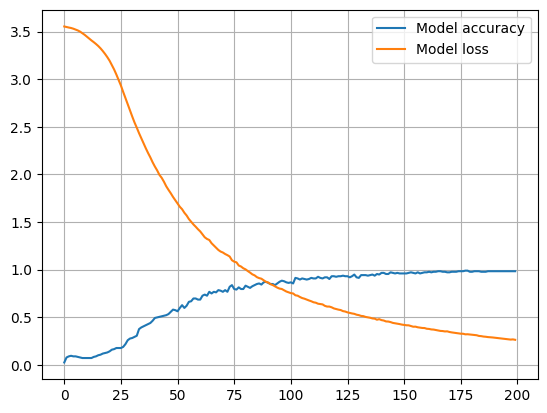

In [16]:
plt.plot(history.history['accuracy'], label = "Model accuracy")
plt.plot(history.history['loss'], label = "Model loss")
plt.legend()
plt.grid()

# Testing frenshi
Finally, let's chat with Frenshi a little bit about the administrative formalities in France for foreign students.

In [17]:
import random
while True:
  texts_p = []
  prediction_input = input("You:")
  #Preprocessing the user's input
  prediction_input = [ltrs.lower() for ltrs in prediction_input if ltrs not in string.punctuation]
  prediction_input = ''.join(prediction_input)
  prediction_inputTmp = prediction_input
  texts_p.append(prediction_input)
  #Tokenizing the user's input
  prediction_input = tokenizer.texts_to_sequences(texts_p)
  prediction_input = np.array(prediction_input).reshape(-1)
  #Apply padding
  prediction_input = pad_sequences([prediction_input], input_shape)
  #Perform prediction on user's input
  output = model.predict(prediction_input)
  output = output.argmax()
  #Convert model output back to text
  response_tag = labelEnc.inverse_transform([output])[0]
  try:
        index_input = data['inputs'].values.tolist().index(prediction_inputTmp)
  except ValueError:
        print("Frenshi: Desolée! j'ai pas pu trouver des reponses à votre question. Veuillez s'il vous plait essayer les proposition suivantes:\n CAF, sécurité sociale et titre de sèjour. Merci!")
        continue;
  #print the best answer to the user's input
  print("Frenshi:", random.choice(responses[response_tag]))
  if response_tag == "goodbyeDay" or response_tag == "goodbyeEvening":
    break

You:Salut
1/1 [==============================] - 0s 445ms/step
Frenshi: Bonjour! Je suis Frenshi! je suis là pour vous aider et accompagner dans vos démarches administratives en france. Les démarches administratives sont souvent un vrai casse-téte, d'autant plus pour les étudiants étrangers arrivant dans un nouveau pays. Mais ne vous inquiétez pas! Je suis là pour vous! Pour commenencer veuillez choisir parmi les propositions suivantes:
CAF, titre de sèjour ou sècurité sociale
You:CAF
1/1 [==============================] - 0s 24ms/step
Frenshi: Les étudiants étrangers en France peuvent rencontrer des difficultés pour trouver un logement, en particulier dans les grandes villes universitaires comme Paris. La CAF est une organisation de droit privé située dans chaque département français et offre des prestations pour lutter contre la pauvreté telles que le RSA ou la Prime d'activité, ainsi que des aides au logement telles que l'APL.
You:APL
1/1 [==============================] - 0s 35ms/s